In [ ]:
!pip install gym-maze-trustycoder83
!pip install pyamaze

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from typing import List
import numpy as np
import torch.nn.functional as F
from torch import nn, optim, Tensor
import random
from collections import namedtuple, deque
import os
import csv
from gym import Wrapper
from gym_maze.envs.maze_env import MazeEnvSample5x5
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
gamma=0.99
batch_size=32
lr=0.001
initial_exploration=1000
log_interval=10
update_target=1000
replay_memory_capacity=1000
device="cpu" if torch.cuda.is_available() else "gpu"
sequence_length=32
burn_in_length=4
eta=0.9
local_mini_batch=8
n_step=2
over_lapping_length=16
weight_decay = 1e-5
epsilon_decay=0.00001
random_seed=42
enable_ngu=True
hidden_size=16
filename = ""
if os.path.exists("/content/Results.csv"):
  filename = "/content/Results.csv"
else:
  print("File does not Exist")
PATH = ""
if os.path.exists("/content/checkpoint1.pt"):
  PATH = "/content/checkpoint1.pt"
else:
  print("Invalid path for saving and loading")

#Embedding Model

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(self, obs_size, num_outputs):
        super(EmbeddingModel, self).__init__()
        self.obs_size = obs_size
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.last = nn.Linear(32 * 2, num_outputs)

        self.optimizer = optim.Adam(self.parameters(), lr=1e-5)

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x = torch.cat([x1, x2], dim=2)
        x = self.last(x)
        return nn.Softmax(dim=2)(x)

    def embedding(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def train_model(self, batch):
        batch_size = torch.stack(batch.state).size()[0]
        
        states = torch.stack(batch.state).view(batch_size, sequence_length, self.obs_size)[:, -5:, :]
        next_states = torch.stack(batch.next_state).view(batch_size, sequence_length, self.obs_size)[:, -5:, :]
        actions = torch.stack(batch.action).view(batch_size, sequence_length, -1).long()[:, -5:, :]

        self.optimizer.zero_grad()
        net_out = self.forward(states, next_states)
        actions_one_hot = torch.squeeze(F.one_hot(actions, self.num_outputs)).float()
        loss = nn.MSELoss()(net_out, actions_one_hot)
        loss.backward()
        self.optimizer.step()
        return loss.item()


def compute_intrinsic_reward(
    episodic_memory: List,
    current_c_state: Tensor,
    k=10,
    kernel_cluster_distance=0.008,
    kernel_epsilon=0.0001,
    c=0.001,
    sm=8,
):
    state_dist = [(c_state, torch.dist(c_state, current_c_state)) for c_state in episodic_memory]
    state_dist.sort(key=lambda x: x[1])
    state_dist = state_dist[:k]
    dist = [d[1].item() for d in state_dist]
    dist = np.array(dist)

    dist = dist / np.mean(dist)

    dist = np.max(dist - kernel_cluster_distance, 0)
    kernel = kernel_epsilon / (dist + kernel_epsilon)
    s = np.sqrt(np.sum(kernel)) + c

    if np.isnan(s) or s > sm:
        return 0
    return 1 / s

#Model

In [ ]:
class R2D2(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(R2D2, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 128)
        self.fc_adv = nn.Linear(128, num_outputs)
        self.fc_val = nn.Linear(128, 1)

    def forward(self, x, hidden=None):
        batch_size = x.size()[0]
        sequence_length = x.size()[1]
        out, hidden = self.lstm(x, hidden)

        out = F.relu(self.fc(out))
        adv = self.fc_adv(out)
        adv = adv.view(batch_size, sequence_length, self.num_outputs)
        val = self.fc_val(out)
        val = val.view(batch_size, sequence_length, 1)

        qvalue = val + (adv - adv.mean(dim=2, keepdim=True))

        return qvalue, hidden

    @classmethod
    def get_td_error(cls, online_net, target_net, batch, lengths):
        def slice_burn_in(item):
            return item[:, burn_in_length :, :]

        batch_size = torch.stack(batch.state).size()[0]
        states = torch.stack(batch.state).view(batch_size, sequence_length, online_net.num_inputs)
        next_states = torch.stack(batch.next_state).view(batch_size, sequence_length, online_net.num_inputs)
        actions = torch.stack(batch.action).view(batch_size, sequence_length, -1).long()
        rewards = torch.stack(batch.reward).view(batch_size, sequence_length, -1)
        masks = torch.stack(batch.mask).view(batch_size, sequence_length, -1)
        steps = torch.stack(batch.step).view(batch_size, sequence_length, -1)
        rnn_state = torch.stack(batch.rnn_state).view(batch_size, sequence_length, 2, -1)

        [h0, c0] = rnn_state[:, 0, :, :].transpose(0, 1)
        h0 = h0.unsqueeze(0).detach()
        c0 = c0.unsqueeze(0).detach()

        [h1, c1] = rnn_state[:, 1, :, :].transpose(0, 1)
        h1 = h1.unsqueeze(0).detach()
        c1 = c1.unsqueeze(0).detach()

        pred, _ = online_net(states, (h0, c0))
        next_pred, _ = target_net(next_states, (h1, c1))

        next_pred_online, _ = online_net(next_states, (h1, c1))

        pred = slice_burn_in(pred)
        next_pred = slice_burn_in(next_pred)
        actions = slice_burn_in(actions)
        rewards = slice_burn_in(rewards)
        masks = slice_burn_in(masks)
        steps = slice_burn_in(steps)
        next_pred_online = slice_burn_in(next_pred_online)

        pred = pred.gather(2, actions)

        _, next_pred_online_action = next_pred_online.max(2)

        target = rewards + masks * pow(gamma, steps) * next_pred.gather(2, next_pred_online_action.unsqueeze(2))

        td_error = pred - target.detach()

        for idx, length in enumerate(lengths):
            td_error[idx][length - burn_in_length :][:] = 0

        return td_error

    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch, lengths):
        td_error = cls.get_td_error(online_net, target_net, batch, lengths)

        loss = pow(td_error, 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss, td_error

    def get_action(self, state, hidden):
        state = state.unsqueeze(0).unsqueeze(0)

        qvalue, hidden = self.forward(state, hidden)

        _, action = torch.max(qvalue, 2)
        return action.numpy()[0][0], hidden

#Memory

In [ ]:
Transition = namedtuple(
    "Transition",
    ("state", "next_state", "action", "reward", "mask", "step", "rnn_state"),
)


class LocalBuffer(object):
    def __init__(self):
        self.n_step_memory = []
        self.local_memory = []
        self.memory = []
        self.over_lapping_from_prev = []

    def push(self, state, next_state, action, reward, mask, rnn_state):
        self.n_step_memory.append([state, next_state, action, reward, mask, rnn_state])
        if len(self.n_step_memory) == n_step or mask == 0:
            [state, _, action, _, _, rnn_state] = self.n_step_memory[0]
            [_, next_state, _, _, mask, _] = self.n_step_memory[-1]

            sum_reward = 0
            for t in reversed(range(len(self.n_step_memory))):
                [_, _, _, reward, _, _] = self.n_step_memory[t]
                sum_reward += reward + gamma * sum_reward
            reward = sum_reward
            step = len(self.n_step_memory)
            self.push_local_memory(state, next_state, action, reward, mask, step, rnn_state)
            self.n_step_memory = []

    def push_local_memory(self, state, next_state, action, reward, mask, step, rnn_state):
        self.local_memory.append(
            Transition(
                state,
                next_state,
                action,
                reward,
                mask,
                step,
                torch.stack(rnn_state).view(2, -1),
            )
        )
        if (len(self.local_memory) + len(self.over_lapping_from_prev)) == sequence_length or mask == 0:
            self.local_memory = self.over_lapping_from_prev + self.local_memory
            length = len(self.local_memory)
            while len(self.local_memory) < sequence_length:
                self.local_memory.append(
                    Transition(
                        torch.Tensor([0, 0]),
                        torch.Tensor([0, 0]),
                        0,
                        0,
                        0,
                        0,
                        torch.zeros([2, 1, hidden_size]).view(2, -1),
                    )
                )
            self.memory.append([self.local_memory, length])
            if mask == 0:
                self.over_lapping_from_prev = []
            else:
                self.over_lapping_from_prev = self.local_memory[len(self.local_memory) - over_lapping_length :]
            self.local_memory = []

    def sample(self):
        episodes = self.memory
        (
            batch_state,
            batch_next_state,
            batch_action,
            batch_reward,
            batch_mask,
            batch_step,
            batch_rnn_state,
        ) = ([], [], [], [], [], [], [])
        lengths = []
        for episode, length in episodes:
            batch = Transition(*zip(*episode))

            batch_state.append(torch.stack(list(batch.state)))
            batch_next_state.append(torch.stack(list(batch.next_state)))
            batch_action.append(torch.Tensor(list(batch.action)))
            batch_reward.append(torch.Tensor(list(batch.reward)))
            batch_mask.append(torch.Tensor(list(batch.mask)))
            batch_step.append(torch.Tensor(list(batch.step)))
            batch_rnn_state.append(torch.stack(list(batch.rnn_state)))

            lengths.append(length)
        self.memory = []
        return (
            Transition(
                batch_state,
                batch_next_state,
                batch_action,
                batch_reward,
                batch_mask,
                batch_step,
                batch_rnn_state,
            ),
            lengths,
        )


class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.memory_probability = deque(maxlen=capacity)

    def td_error_to_priority(self, td_error, lengths):
        abs_td_error_sum = td_error.abs().sum(dim=1, keepdim=True).view(-1).detach().numpy()
        lengths_burn = [length - burn_in_length + 1 for length in lengths]

        prior_max = td_error.abs().max(dim=1, keepdim=True)[0].view(-1).detach().numpy()

        prior_mean = abs_td_error_sum / lengths_burn
        prior = eta * prior_max + (1 - eta) * prior_mean
        return prior

    def push(self, td_error, batch, lengths):
        
        prior = self.td_error_to_priority(td_error, lengths)

        for i in range(len(batch)):
            self.memory.append(
                [
                    Transition(
                        batch.state[i],
                        batch.next_state[i],
                        batch.action[i],
                        batch.reward[i],
                        batch.mask[i],
                        batch.step[i],
                        batch.rnn_state[i],
                    ),
                    lengths[i],
                ]
            )
            self.memory_probability.append(prior[i])

    def sample(self, batch_size):
        probability = np.array(self.memory_probability)
        probability = probability / probability.sum()

        indexes = np.random.choice(range(len(self.memory_probability)), batch_size, p=probability)
        episodes = [self.memory[idx][0] for idx in indexes]
        lengths = [self.memory[idx][1] for idx in indexes]

        (
            batch_state,
            batch_next_state,
            batch_action,
            batch_reward,
            batch_mask,
            batch_step,
            batch_rnn_state,
        ) = ([], [], [], [], [], [], [])
        for episode in episodes:
            batch_state.append(episode.state)
            batch_next_state.append(episode.next_state)
            batch_action.append(episode.action)
            batch_reward.append(episode.reward)
            batch_mask.append(episode.mask)
            batch_step.append(episode.step)
            batch_rnn_state.append(episode.rnn_state)

        return (
            Transition(
                batch_state,
                batch_next_state,
                batch_action,
                batch_reward,
                batch_mask,
                batch_step,
                batch_rnn_state,
            ),
            indexes,
            lengths,
        )

    def update_priority(self, indexes, td_error, lengths):
        prior = self.td_error_to_priority(td_error, lengths)
        priors_idx = 0
        for idx in indexes:
            self.memory_probability[idx] = prior[priors_idx]
            priors_idx += 1

    def __len__(self):
        return len(self.memory)

#Train

In [ ]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
fields = ["episode", "mean_reward", "epsilon", "embedding_loss", "loss", "mean_augmented_reward", "steps", "sum_obs_set"]

with open(filename, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(fields)


def get_action(state, target_net, epsilon, env, hidden):
    action, hidden = target_net.get_action(state, hidden)

    if np.random.rand() <= epsilon:
        return env.action_space.sample(), hidden
    else:
        return action, hidden


def update_target_model(online_net, target_net):
    target_net.load_state_dict(online_net.state_dict())


class Maze(Wrapper):
    def step(self, action: int):
        obs, rew, done, info = super().step(["N", "E", "S", "W"][action])
        self.set.add((obs[0], obs[1]))
        if rew > 0:
            rew = 10
        return obs / 10, rew, done, info

    def reset(self):
        self.set = set()
        return super().reset()


def main():
    env = Maze(MazeEnvSample5x5())

    resume = True

    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)
    env.action_space.seed(random_seed)

    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    print("state size:", num_inputs)
    print("action size:", num_actions)

    online_net = R2D2(num_inputs, num_actions)
    target_net = R2D2(num_inputs, num_actions)
    update_target_model(online_net, target_net)
    embedding_model = EmbeddingModel(obs_size=num_inputs, num_outputs=num_actions)
    embedding_loss = 0

    optimizer = optim.Adam(online_net.parameters(), lr=lr, weight_decay=weight_decay)

    online_net.to(device)
    target_net.to(device)
    online_net.train()
    target_net.train()
    memory = Memory(replay_memory_capacity)
    local_buffer = LocalBuffer()
    epsilon = 1.0
    steps = 0
    loss = 0
    start_episode = 0

    if resume:
      checkpoint = torch.load(PATH)
      online_net = online_net.load_state_dict(checkpoint["online_net"])
      target_net = target_net.load_state_dict(checkpoint["target_net"])
      embedding_model = embedding_model.load_state_dict(checkpoint["embedding_model"])
      optimizer = optimizer.load_state_dict(checkpoint["optimizer"])
      start_episode = checkpoint["episode"]
      loss = checkpoint["loss"]
      mean_reward = checkpoint["mean_reward"]
      mean_augmented_reward = checkpoint["mean_augmented_reward"]
      steps = checkpoint["steps"]
      epsilon = checkpoint["epsilon"]

    
    sum_reward = 0
    sum_augmented_reward = 0
    sum_obs_set = 0

    for episode in range(start_episode, 7000):
        done = False
        state = env.reset()
        state = torch.Tensor(state).to(device)

        hidden = (
            torch.Tensor().new_zeros(1, 1, hidden_size),
            torch.Tensor().new_zeros(1, 1, hidden_size),
        )

        episodic_memory = [embedding_model.embedding(state)]

        episode_steps = 0
        horizon = 100
        while not done:
            steps += 1
            episode_steps += 1

            action, new_hidden = get_action(state, target_net, epsilon, env, hidden)

            next_state, env_reward, done, _ = env.step(action)
            next_state = torch.Tensor(next_state)

            augmented_reward = env_reward
            if enable_ngu:
                next_state_emb = embedding_model.embedding(next_state)
                intrinsic_reward = compute_intrinsic_reward(episodic_memory, next_state_emb)
                episodic_memory.append(next_state_emb)
                beta = 0.0001
                augmented_reward = env_reward + beta * intrinsic_reward

            mask = 0 if done else 1

            local_buffer.push(state, next_state, action, augmented_reward, mask, hidden)
            hidden = new_hidden
            if len(local_buffer.memory) == local_mini_batch:
                batch, lengths = local_buffer.sample()
                td_error = R2D2.get_td_error(online_net, target_net, batch, lengths)
                memory.push(td_error, batch, lengths)

            sum_reward += env_reward
            state = next_state
            sum_augmented_reward += augmented_reward

            if steps > initial_exploration and len(memory) > batch_size:
                epsilon -= epsilon_decay
                epsilon = max(epsilon, 0.4)

                batch, indexes, lengths = memory.sample(batch_size)
                loss, td_error = R2D2.train_model(online_net, target_net, optimizer, batch, lengths)

                if enable_ngu:
                    embedding_loss = embedding_model.train_model(batch)

                memory.update_priority(indexes, td_error, lengths)

                if steps % update_target == 0:
                    update_target_model(online_net, target_net)

            if episode_steps >= horizon or done:
                sum_obs_set += len(env.set)
                break

        if episode > 0 and episode % log_interval == 0:
            mean_reward = sum_reward / log_interval
            mean_augmented_reward = sum_augmented_reward / log_interval
            metrics = {
                "online_net": online_net.state_dict(),
                "target_net": target_net.state_dict(),
                "embedding_model": embedding_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "episode": episode,
                "mean_reward": mean_reward,
                "epsilon": epsilon,
                "embedding_loss": embedding_loss,
                "loss": loss,
                "mean_augmented_reward": mean_augmented_reward,
                "steps": steps,
                "sum_obs_set": sum_obs_set / log_interval,
            }

            with open(filename, 'a') as csvfile:
              csvwriter = csv.writer(csvfile)
              csvwriter.writerow([episode, mean_reward, epsilon, embedding_loss, loss, mean_augmented_reward, steps, sum_obs_set / log_interval])
            
            
            
            torch.save(metrics, PATH)

            if episode % log_interval == 0:
              for key in metrics.keys():
                if key != "online_net" and key != "target_net" and key != "embedding_model" and key != "optimizer":
                  print(f'{key} : {metrics[key]}', end=" ")
                  # print("This is the value of memory: ", memory.memory)
            # break
              print()
            
            sum_reward = 0
            sum_augmented_reward = 0
            sum_obs_set = 0


if __name__ == "__main__":
    main()

state size: 2
action size: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


episode : 10 mean_reward : -0.43999999999999584 epsilon : 1.0 embedding_loss : 0 loss : 0 mean_augmented_reward : 0.46580447844277684 steps : 1100 sum_obs_set : 10.5 


KeyboardInterrupt: ignored

#Results

### Mean Reward vs Episode

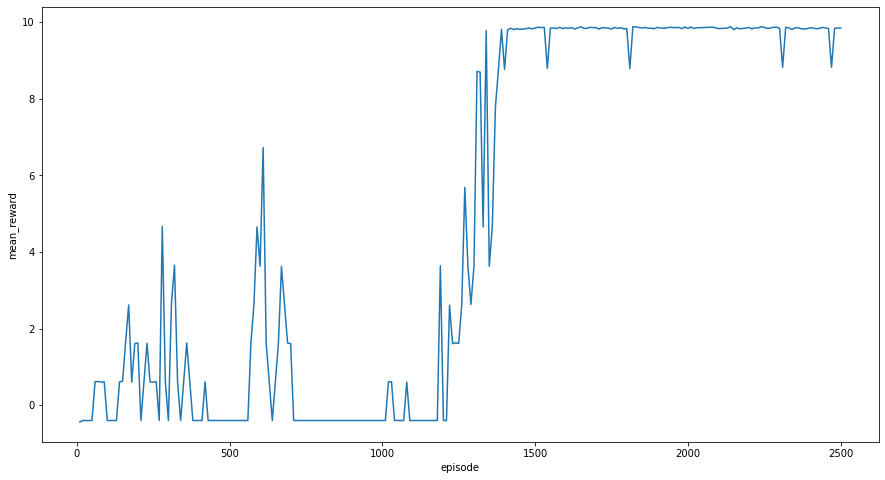

In [ ]:
data = pd.read_csv(filename)

plt.figure(figsize=(15,8))
plt.xlabel("episode")
plt.ylabel("mean_reward")
plt.plot(data[['episode']], data[['mean_reward']])
plt.show()

### Loss vs Episode

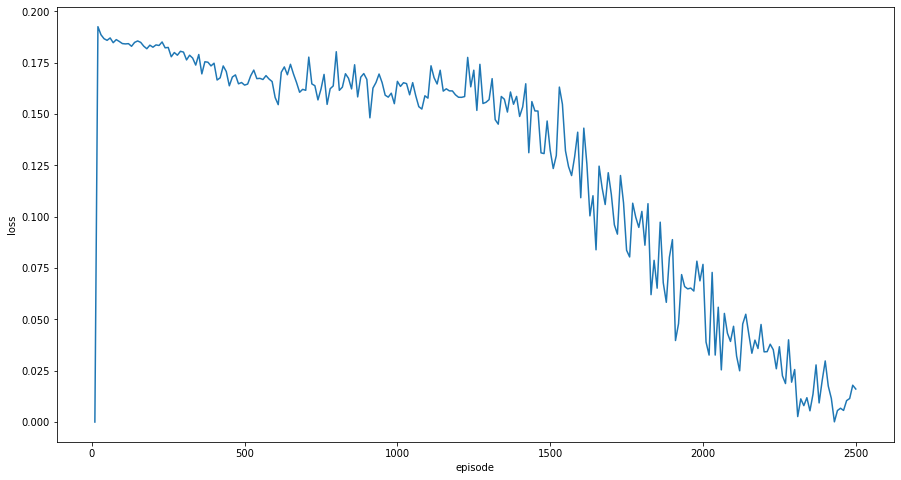

In [ ]:
plt.figure(figsize=(15,8))
plt.xlabel("episode")
plt.ylabel("loss")
plt.plot(data[['episode']], data[['embedding_loss']])
plt.show()

### Mean Augmented Reward vs Episode

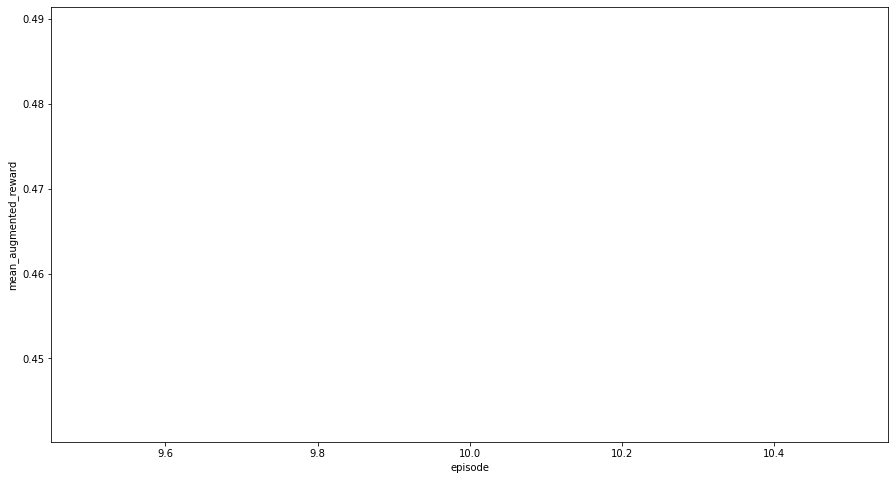

In [ ]:
plt.figure(figsize=(15,8))
plt.xlabel("episode")
plt.ylabel("mean_augmented_reward")
plt.plot(data[['episode']], data[['mean_augmented_reward']])
plt.show()